In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader 

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

In [3]:
train_dataset = torchvision.datasets.FashionMNIST("./data", download=True,
    transform=transforms.Compose([ transforms.ToTensor()]))
test_dataset = torchvision.datasets.FashionMNIST("./data", download=True,
    train=False, transform=transforms.Compose([transforms.ToTensor()]))

In [4]:
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=100)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100) 

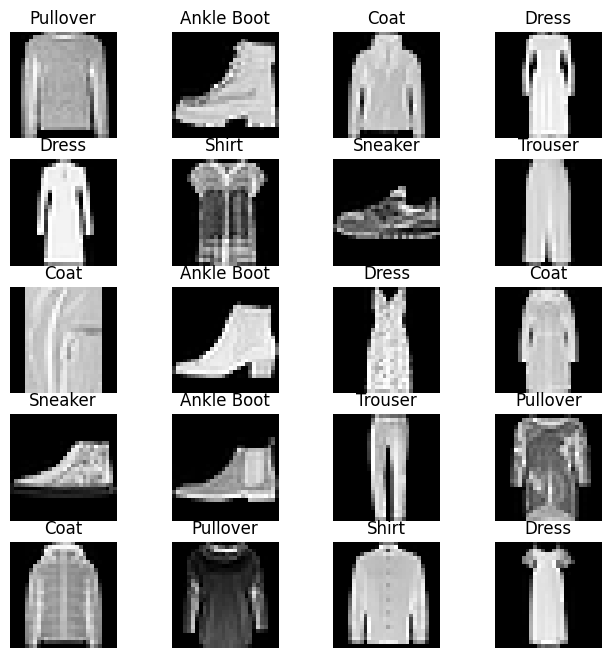

In [5]:
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt', 7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'}
fig = plt.figure(figsize=(8,8));
columns = 4;
rows = 5;
for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(train_dataset)); 
    img = train_dataset[img_xy][0][0,:,:] 
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show() 

In [6]:
class FashionDNN(nn.Module):
    def __init__(self): 
        super(FashionDNN, self).__init__()
        self.fc1 = nn.Linear(in_features=784, out_features=256)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10) 
    def forward(self, input_data):
        out = input_data.view(-1, 784)
        out = F.relu(self.fc1(out))
        out = self.drop(out)
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out 


In [7]:
import torch
import torch.nn as nn

inputs = torch.randn(64, 3, 244, 244) 
conv = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
outputs = conv(inputs)
layer = nn.Conv2d(1, 1, 3)

In [8]:
import torch.nn.functional as F
inputs = torch.randn(64, 3, 244, 244)
weight = torch.randn(64, 3, 3, 3)
bias = torch.randn(64)
outputs = F.conv2d(inputs, weight, bias, padding=1)

In [9]:
learning_rate =0.001;
model = FashionDNN();
model .to(device)
criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate); 
print(model) 

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [10]:
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    print(f"epoch = {epoch}")
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)

        outputs = model(train)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        count += 1

        if not (count % 50):
            total = 0
            correct = 0

            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)

                test = Variable(images.view(100, 1, 28, 28))
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)

            accuracy = 100 * correct / total
            loss_list.append(loss.data.item())
            iteration_list.append(count)
            accuracy_list.append(accuracy)

            if not (count % 500):
                print("Iteration: {}, Loss: {}, Accuracy: {:.2f}%".format(count, loss.data, accuracy))


epoch = 0
Iteration: 500, Loss: 0.583213746547699, Accuracy: 83.02%
epoch = 1
Iteration: 1000, Loss: 0.48283669352531433, Accuracy: 84.46%
epoch = 2
Iteration: 1500, Loss: 0.3446572422981262, Accuracy: 84.24%
epoch = 3
Iteration: 2000, Loss: 0.3311176300048828, Accuracy: 85.87%
epoch = 4
Iteration: 2500, Loss: 0.27397269010543823, Accuracy: 86.04%
Iteration: 3000, Loss: 0.27216529846191406, Accuracy: 86.55%


In [38]:
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )


        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2) 
        )

        self.fc1 = nn.Linear(in_features=32 * 6 * 6, out_features=600)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10) # 마지막 계층의 out_features는 클래스 개수를 의미

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)

        return out


In [41]:
learning_rate =0.001;
model = FashionCNN();
model.to(device)
criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate);
print(model) 

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1152, out_features=600, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [40]:
num_epochs = 10
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
predictions_list = []
labels_list = []

for epoch in range(num_epochs): 
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)

        outputs = model(train)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        count += 1

        if not (count % 50):
            total = 0
            correct = 0

            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100, 1, 28, 28))

                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)

            accuracy = 100 * correct / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

            if not (count % 500):
                print("Iteration: {}, Loss: {}, Accuracy: {:.2f}%".format(count, loss.data, accuracy))


Iteration: 500, Loss: 0.5347743034362793, Accuracy: 84.47%
Iteration: 1000, Loss: 0.32913005352020264, Accuracy: 87.89%
Iteration: 1500, Loss: 0.29291829466819763, Accuracy: 86.66%
Iteration: 2000, Loss: 0.320567786693573, Accuracy: 88.39%
Iteration: 2500, Loss: 0.18601109087467194, Accuracy: 88.45%
Iteration: 3000, Loss: 0.23508289456367493, Accuracy: 87.20%
Iteration: 3500, Loss: 0.25625476241111755, Accuracy: 88.90%
Iteration: 4000, Loss: 0.3365236222743988, Accuracy: 88.46%
Iteration: 4500, Loss: 0.32906249165534973, Accuracy: 86.29%
Iteration: 5000, Loss: 0.3258872330188751, Accuracy: 87.99%
Iteration: 5500, Loss: 0.2488880753517151, Accuracy: 86.82%
Iteration: 6000, Loss: 0.20157158374786377, Accuracy: 87.48%
